# Characterizing transactions between primary miners in Ethereum

In [237]:
# Toggle feature to hide code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Libraries and Data

In [84]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from scipy.stats import powerlaw
import sys, os
sys.path.append('/Users/dsrincon/Dropbox/Personal/EDU/Posgrado/masters_usa/MIMS/research/miner_network/miner_network_analysis/nxcontrol/nxcontrol')

import nxcontrol as nxc # Control library for networkx 

In [5]:
#Load data
latest_miners=pd.read_csv('data/miners.csv',index_col=0)
edges_evolution=np.load('data/dir_miner_trans_edges.npy',allow_pickle=True)


In [6]:
# Set miners with NaN in no. blocks to 1 
print('Miners with no. blocks = NaN: {} '.format(len(latest_miners.loc[latest_miners['no. blocks'].isnull()])))
latest_miners.loc[latest_miners['no. blocks'].isnull(),'no. blocks']=1
print('Miners with no. blocks = NaN: {} '.format(len(latest_miners.loc[latest_miners['no. blocks'].isnull()])))

Miners with no. blocks = NaN: 17 
Miners with no. blocks = NaN: 0 


In [7]:
# Constants

wei_to_eth=1000000000000000000
eth_to_usd=183.44 # 17 nov 2019, 5:09:00 PT

In [8]:
latest_miners.head()

,miner,no. blocks,no. transactions,unique tags,miner_tag,miner_id
0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,1677231.0,158881295.0,137.0,×\nGethgo1.5.1 linux,0
1,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,961958.0,66720193.0,33.0,Ü,1
2,0x2a65aca4d5fc5b5c859090a6c34d164135398226,933307.0,19097355.0,24.0,×Gethgo1.6.2 linux,2
3,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,861883.0,96817057.0,116.0,ÞParity-Ethereum1.36.0li,3
4,0x829bd824b016326a401d083b33d092293333a830,799757.0,89240980.0,901.0,ä¸å½©ç¥ä»é±¼ÿû®,4


In [9]:
latest_miners.describe()

,no. blocks,no. transactions,unique tags,miner_id
count,4.985000e+03,4.968000e+03,4968.000000,4985.000000
mean,1.777990e+03,1.156248e+05,13.828704,2492.000000
std,3.648159e+04,3.156767e+06,389.554789,1439.189876
min,1.000000e+00,0.000000e+00,1.000000,0.000000
25%,1.000000e+00,1.000000e+00,1.000000,1246.000000
50%,4.000000e+00,1.600000e+01,1.000000,2492.000000
75%,2.300000e+01,1.130000e+02,2.000000,3738.000000
max,1.677231e+06,1.588813e+08,19560.000000,4984.000000


In [10]:
# Details about the numpy array loaded from disk
print(edges_evolution.shape)
print(edges_evolution[-1][:5])

(51,)
[(3220, 3343, {'value': 1.00312470891818e+19}), (2195, 3373, {'value': 5e+17}), (3189, 1870, {'value': 1.3944568847054053e+19}), (40, 3745, {'value': 1.1305426449e+19}), (40, 1205, {'value': 8.528144230250004e+20})]


We extracted data from all the blocks and transactions in the ethereum network between its launch in July 30, 2015 (block 0) and November 3, 2019 (block 8,863,264) using the data in the publicly available BigQuery ethereum dataset. 

## General mining statistics

**Number of miners**

In [102]:
# Basic mining Statistics
# TODO: gas and rewards statistics
# TODO: Evolution of mining statistics 
# TODO: Evolution of mining share of the market (flow diagram)

blocks_list_final=np.sort(latest_miners['no. blocks'].to_numpy().astype(int))[::-1]

block_list_final_l=len(blocks_list_final)
total_blocks=blocks_list_final.sum()
total_miners=len(blocks_list_final)

blocks_mean_final=blocks_list_final.mean()

blocks_median_final=np.median(blocks_list_final)

blocks_percentile_10=int(block_list_final_l*0.1)
blocks_percentile_10_value=blocks_list_final[:blocks_percentile_10+1].sum()
blocks_percentile_10_per=(blocks_percentile_10_value/total_blocks)*100

blocks_percentile_01=int(block_list_final_l*0.01)
blocks_percentile_01_value=blocks_list_final[:blocks_percentile_01+1].sum()
blocks_percentile_01_per=(blocks_percentile_01_value/total_blocks)*100

blocks_gini_final=gini(blocks_list_final)

# Estimating de Herfindahl–Hirschman Index (HHI) Benchmark: https://rooseveltinstitute.org/wp-content/uploads/2018/09/The-United-States-has-a-market-concentration-problem-brief-final.pdf

hhh_index=np.power(blocks_list_final*100/total_blocks,2).sum()


print('Total number of blocks mined (30 Jul 2015 - 03 Nov 2019):{:,}'.format(total_blocks))
print('Total number of transactions mined  :{:,}'.format(int(latest_miners['no. transactions'].sum())))
print('Total number of miners (<date>):{:,}'.format(total_miners))
print('Mean value of blocks mined per miner: {:,.0f}'.format(blocks_mean_final))
print('Median value of blocks mined per miner: {:,.0f}'.format(blocks_median_final))
print('Blocks mined by top 10% of miners: {:,.0f} ({:.0f}% of all value)'
      .format(blocks_percentile_10_value,blocks_percentile_10_per))
print('Blocks mined by top 1% of miners: {:,.0f} ({:.0f}% of all value)'
      .format(blocks_percentile_01_value,blocks_percentile_01_per))
print('Gini coefficient of blocks mined: {:,.3f}'.format(blocks_gini_final))
print('HHI Index: {}'.format(hhh_index))




Total number of blocks mined (30 Jul 2015 - 03 Nov 2019):8,863,281
Total number of transactions mined  :574,423,867
Total number of miners (<date>):4,985
Mean value of blocks mined per miner: 1,778
Median value of blocks mined per miner: 4
Blocks mined by top 10% of miners: 8,801,282 (99% of all value)
Blocks mined by top 1% of miners: 8,220,128 (93% of all value)
Gini coefficient of blocks mined: 0.991
HHI Index: 846.3833229989456
4.901960784313726


<BarContainer object of 4985 artists>

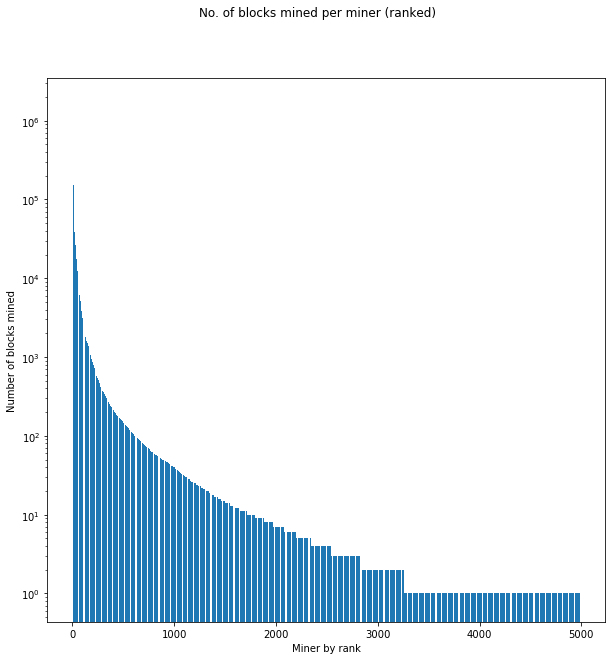

In [19]:
# Graph mining volume by miner 
y_pos = np.arange(len(blocks_list_final))
fig,ax=plt.subplots(figsize=(10,10))
plt.yscale('log')
fig.suptitle('No. of blocks mined per miner (ranked)')
plt.xlabel('Miner by rank')
plt.ylabel('Number of blocks mined')
plt.bar(y_pos,blocks_list_final)

Total number of blocks mined by top 10 miners:6,782,405.0 (77% of all blocks)


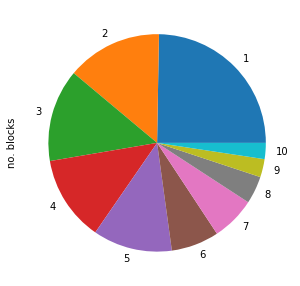

In [83]:
blocks_top10=latest_miners['no. blocks'][:10].sum()
print('Total number of blocks mined by top 10 miners:{:,} ({:.0f}% of all blocks)'.format(blocks_top10,100*blocks_top10/total_blocks))
latest_miners[:10].plot.pie(x='miner_tag',y='no. blocks', figsize=(5, 5),legend=False, labels=[1,2,3,4,5,6,7,8,9,10])



## Basic Network analysis

**Network Definition**

We define the miner transaction network as a **weighted directed graph** by selecting all transactions done between miners over the period of study. Every miner defines a node and an edge is drawn between two miners if there has ever been a transaction between them. A node A is weighted by the number of blocks mined by it and an edge (A,B) receives a weight equivalent to all the transactions made from A to B. 

In [20]:
# Define nodes, edges and graph
final_edges=edges_evolution[-1]
weighted_nodes=[(x,{'blocks':b}) for x,b in zip(latest_miners['miner_id'],latest_miners['no. blocks'])]
G_final=nx.DiGraph()
G_final.add_nodes_from(weighted_nodes)
G_final.add_edges_from(final_edges)
G_final_edges=[(n1,n2,a['value']) for n1,n2,a in G_final.edges(data=True)]

**Inter miner Transactions**

In [21]:
# Basic transaction Graph Statistics

# TODO: Calculate total transaction volumne (number of transactions)
# TODO: Calculate total miner rewards and the transaction relationship volume as a percentage of this volume

value_trans_list_final=np.sort(np.array([(w['value']/wei_to_eth)*eth_to_usd for e0,e1,w in final_edges]))[::-1]
value_trans_list_final_l=len(value_trans_list_final)

value_trans_final=value_trans_list_final.sum()
value_trans_mean_final=value_trans_list_final.mean()
value_trans_median_final=np.median(value_trans_list_final)

percentile_10=int(value_trans_list_final_l*0.1)
percentile_10_value=value_trans_list_final[:percentile_10+1].sum()
percentile_10_per=(percentile_10_value/value_trans_final)*100

percentile_01=int(value_trans_list_final_l*0.01)
percentile_01_value=value_trans_list_final[:percentile_01+1].sum()
percentile_01_per=(percentile_01_value/value_trans_final)*100

gini_final=gini(value_trans_list_final)



print('Total transaction relationships (connections) between miners: {:,}'.format(len(final_edges)))
print('Total value of transaction relationships: ${:,.0f}'.format(value_trans_final))
print('Mean value of transaction relationship: ${:,.0f}'.format(value_trans_mean_final))
print('Median value of transaction relationship: ${:,.0f}'.format(value_trans_median_final))
print('Value transacted by top 10% of relationships: ${:,.0f} ({:.0f}% of all value)'
      .format(percentile_10_value,percentile_10_per))
print('Value transacted by top 1% of relationships: ${:,.0f} ({:.0f}% of all value)'
      .format(percentile_01_value,percentile_01_per))
print('Gini coefficient of transaction relationships distribution: {:,.3f}'.format(gini_final))



Total transaction relationships (connections) between miners: 5,293
Total value of transaction relationships: $345,313,737
Mean value of transaction relationship: $65,240
Median value of transaction relationship: $1,289
Value transacted by top 10% of relationships: $317,565,506 (92% of all value)
Value transacted by top 1% of relationships: $220,934,830 (64% of all value)
Gini coefficient of transaction relationships distribution: 0.943


<BarContainer object of 5293 artists>

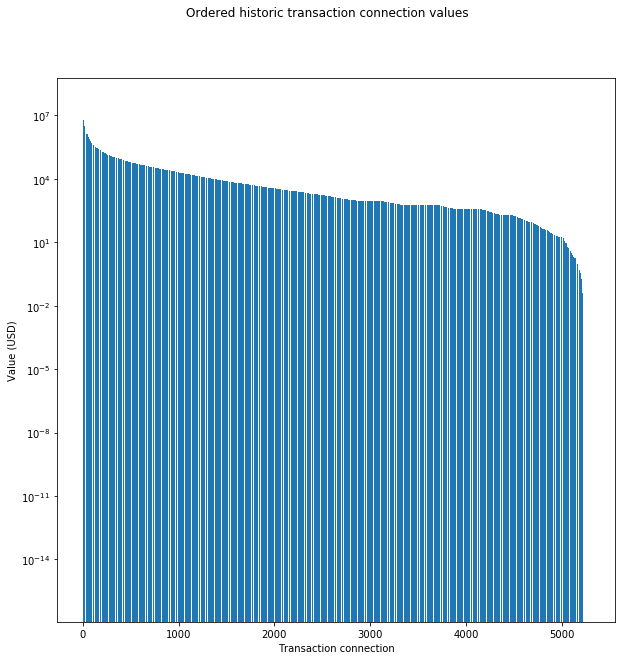

In [22]:
# Graph distribution of transaction values
y_pos = np.arange(len(value_trans_list_final))
fig,ax=plt.subplots(figsize=(10,10))
plt.yscale('log')
fig.suptitle('Ordered historic transaction connection values')
plt.xlabel('Transaction connection')
plt.ylabel('Value (USD)')
plt.bar(y_pos,value_trans_list_final)

In [122]:
# Calculate the value of transactions where the top 10 miners are involved

# Extract all edges that involve top 10 miners
top_10_miners=np.arange(10)
bottom_miners=set(G_final.nodes()).difference(set(top_10_miners))
inedges_top10_final=[(n1,n2,a['value']) for n1,n2,a in G_final.in_edges(top_10_miners,data=True)]
outedges_top10_final=[(n1,n2,a['value']) for n1,n2,a in G_final.out_edges(top_10_miners,data=True)]
edges_top10_final=list(set(inedges_top10_final+outedges_top10_final))

# Calculate value of edges from top 10 miners

top10_value_list_final=np.array([t[2] for t in edges_top10_final])
top10_invalue_list_final=np.array([t[2] for t in inedges_top10_final])
top10_outvalue_list_final=np.array([t[2] for t in outedges_top10_final])

top10_invalue_final=(top10_invalue_list_final.sum()/wei_to_eth)*eth_to_usd
top10_outvalue_final=(top10_outvalue_list_final.sum()/wei_to_eth)*eth_to_usd
top10_value_final=(top10_value_list_final.sum()/wei_to_eth)*eth_to_usd


print('Total in-value transacted by top 10 miners: ${:,.0f} ({:.0f}% of all value)'.
      format(top10_invalue_final,100*top10_invalue_final/value_trans_final))

print('Total out-value transacted by top 10 miners: ${:,.0f} ({:.0f}% of all value)'.
      format(top10_outvalue_final,100*top10_outvalue_final/value_trans_final))

print('Total value transacted by top 10 miners: ${:,.0f} ({:.0f}% of all value)'.
      format(top10_value_final,100*top10_value_final/value_trans_final))


# Extract edges for different parts of the graph

#---Edges
top10_bottom_edges=[e for e in G_final.edges(data=True) if e[0] in top_10_miners and 
                  e[1] in bottom_miners]
bottom_top10_edges=[e for e in G_final.edges(data=True) if e[0] in bottom_miners and 
                  e[1] in top_10_miners]
bottom_bottom_edges=[e for e in G_final.edges(data=True) if e[0] in bottom_miners and 
                  e[1] in bottom_miners]
top10_top10_edges=[e for e in G_final.edges(data=True) if e[0] in top_10_miners and 
                  e[1] in top_10_miners]

#---Value
top10_bottom_value=np.array([e[2]['value'] for e in top10_bottom_edges]).sum()*(eth_to_usd/wei_to_eth)
bottom_top10_value=np.array([e[2]['value'] for e in bottom_top10_edges]).sum()*(eth_to_usd/wei_to_eth)
bottom_bottom_value=np.array([e[2]['value'] for e in bottom_bottom_edges]).sum()*(eth_to_usd/wei_to_eth)
top10_top10_value=np.array([e[2]['value'] for e in top10_top10_edges]).sum()*(eth_to_usd/wei_to_eth)

print('-------')


print('---top10->bottom')
print('Edges from top10 to bottom: {:.0f} ({:.0f}% of all edges )'
      .format(len(top10_bottom_edges),(len(top10_bottom_edges)/len(G_final_edges))*100))
print('Value transacted from top10 to bottom: ${:,.0f} ({:.0f}% of all value)'.
      format(top10_bottom_value,(top10_bottom_value/value_trans_final)*100))
print('---bottom->top10')
print('Edges from bottom to top10: {:.0f} ({:.0f}% of all edges )'
      .format(len(bottom_top10_edges),(len(bottom_top10_edges)/len(G_final_edges))*100))
print('Value transacted from bottom to top10: ${:,.0f} ({:.0f}% of all value)'.
      format(bottom_top10_value,(bottom_top10_value/value_trans_final)*100))
print('---top10->top10')
print('Edges within top10: {:.0f} ({:.0f}% of all edges )'
      .format(len(top10_top10_edges),(len(top10_top10_edges)/len(G_final_edges))*100))
print('Value transacted within top10: ${:,.0f} ({:.0f}% of all value)'.
      format(top10_top10_value,(top10_top10_value/value_trans_final)*100))
print('---bottom->bottom')
print('Edges within bottom: {:.0f} ({:.0f}% of all edges )'
      .format(len(bottom_bottom_edges),(len(bottom_bottom_edges)/len(G_final_edges))*100))
print('Value transacted within bottom: ${:,.0f} ({:.0f}% of all value)'.
      format(bottom_bottom_value,(bottom_bottom_value/value_trans_final)*100))

Total in-value transacted by top 10 miners: $69,045,825 (20% of all value)
Total out-value transacted by top 10 miners: $156,380,926 (45% of all value)
Total value transacted by top 10 miners: $217,356,194 (63% of all value)
-------
---top10->bottom
Edges from top10 to bottom: 1788 (34% of all edges )
Value transacted from top10 to bottom: $148,310,369 (43% of all value)
---bottom->top10
Edges from bottom to top10: 17 (0% of all edges )
Value transacted from bottom to top10: $60,975,268 (18% of all value)
---top10->top10
Edges within top10: 17 (0% of all edges )
Value transacted within top10: $8,070,557 (2% of all value)
---bottom->bottom
Edges within bottom: 3471 (66% of all edges )
Value transacted within bottom: $127,957,543 (37% of all value)


**General Network Structure**

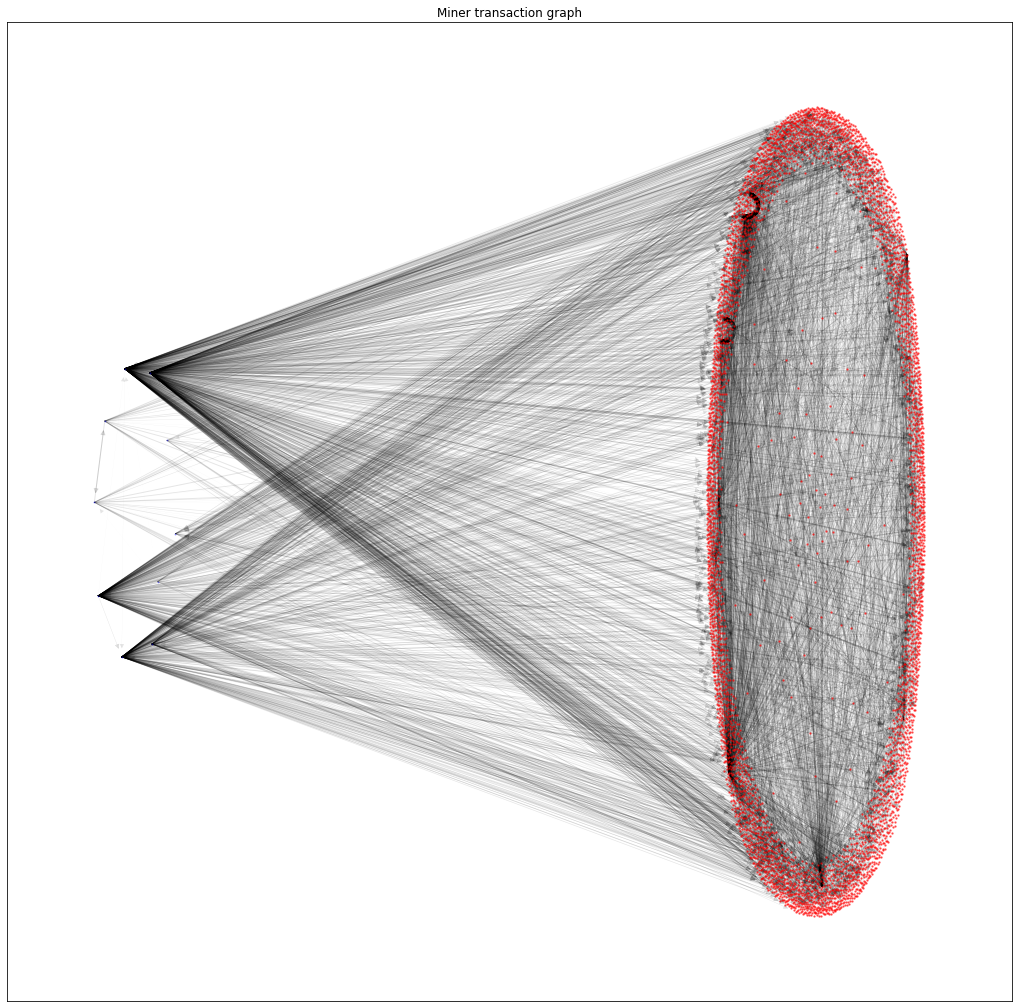

In [132]:
#TODO: Draw graph
fig=plt.figure(figsize=(18,18))
nodes_1=latest_miners['miner_id'][:10].tolist()
nodes_2=latest_miners['miner_id'][10:].tolist()
draw_2node_graph(fig,G_final,nodes_1,nodes_2,G_final.edges(data=True),'value',111,edge_type='')

**Density**

In [107]:
# Calculate density and diameter measures
density_final=nx.classes.function.density(G_final)

print('Density for Final graph: {:,.8f}'.format(density_final))


Density for Final graph: 0.00021304


In [111]:
# Higher bound for all network density
total_address= 79181368
total_net_dens=int(latest_miners['no. transactions'].sum())/(total_address*(total_address-1))

print('Higher bound for total ethereum transaction network density: {:,.8f}'.format(total_net_dens))    
print('Miner transaction network is at least {:,.0f} times more dense than overall network'.format(density_final/total_net_dens))

Higher bound for total ethereum transaction network density: 0.00000009
Miner transaction network is at least 2,325 times more dense than overall network


**Degree distribution**

In [24]:
# Weighted in/out-degree distributions for top 10 nodes
nodes_final=sorted([n for n in G_final.nodes()])
indegree_top10w=np.sort(np.array([d for n,d in G_final.in_degree(top_10_miners,weight='value')])*(eth_to_usd/wei_to_eth))[::-1]
outdegree_top10w=np.sort(np.array([d for n,d in G_final.out_degree(top_10_miners,weight='value')])*(eth_to_usd/wei_to_eth))[::-1]
mean_indegree_top10w=indegree_top10w.mean()
mean_outdegree_top10w=outdegree_top10w.mean()

print('Average weighted in-degree for top 10 nodes: ${:,.0f}'.format(mean_indegree_top10w))
print('Average weighted out-degree for top 10 nodes: ${:,.0f}'.format(mean_outdegree_top10w))


Average weighted in-degree for top 10 nodes: $6,904,582
Average weighted out-degree for top 10 nodes: $15,638,093


In [25]:
# Weighted in/out-degree distributions for bottom nodes (total nodes - top 10 nodes)
bottom_miners=nodes_final[10:]
indegree_bottomw=np.sort(np.array([d for n,d in G_final.in_degree(bottom_miners,weight='value')])*(eth_to_usd/wei_to_eth))[::-1]
outdegree_bottomw=np.sort(np.array([d for n,d in G_final.out_degree(bottom_miners,weight='value')])*(eth_to_usd/wei_to_eth))[::-1]
mean_indegree_bottomw=indegree_bottomw.mean()
mean_outdegree_bottomw=outdegree_bottomw.mean()

print('Average weighted in-degree for bottom nodes: ${:,.0f}'.format(mean_indegree_bottomw))
print('Average weighted out-degree for bottom nodes: ${:,.0f}'.format(mean_outdegree_bottomw))

Average weighted in-degree for bottom nodes: $55,531
Average weighted out-degree for bottom nodes: $37,976


60457076
43592397


<BarContainer object of 4975 artists>

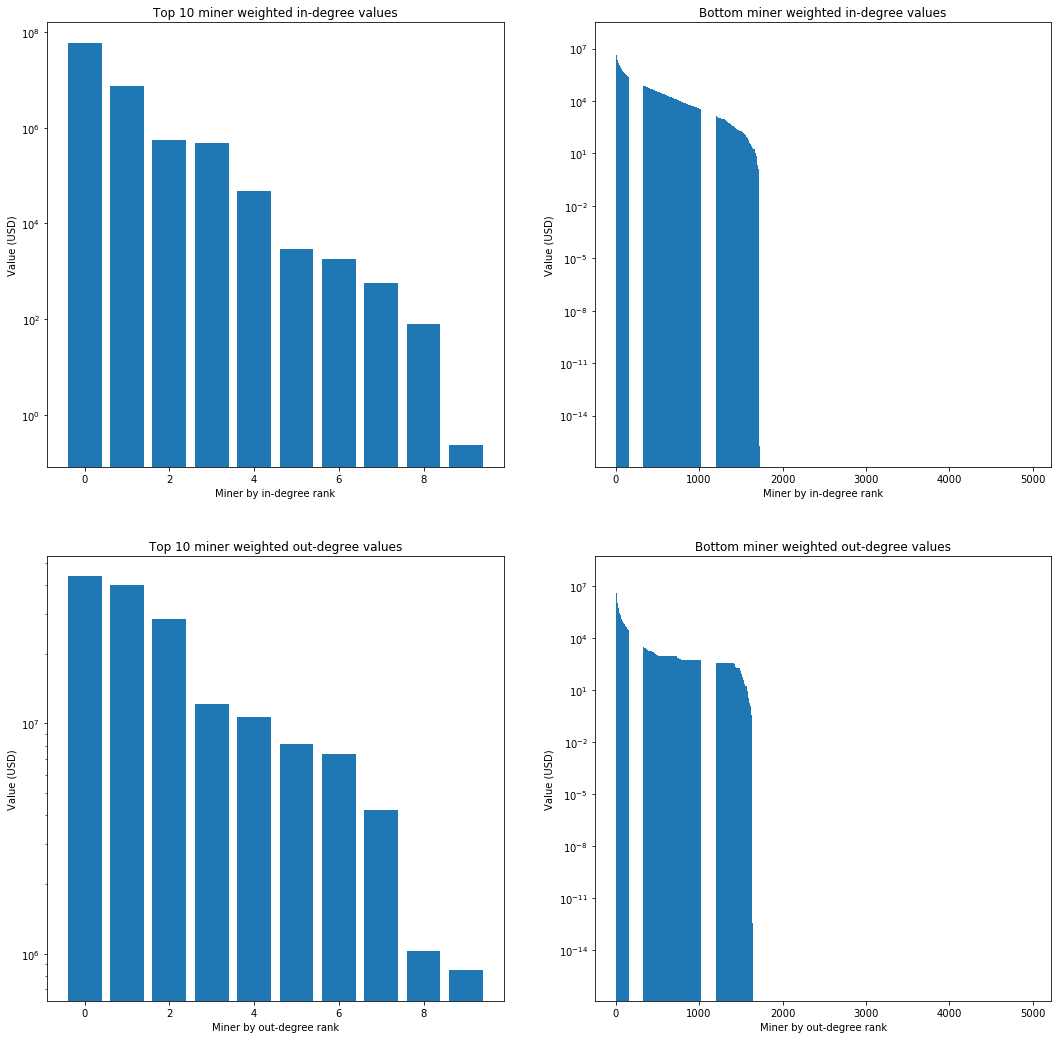

In [103]:
fig=plt.figure(figsize=(18,18))
#plt.gca().set_aspect('equal', adjustable='box')

max_in_degree=int(max(indegree_top10w[0],indegree_bottomw[0]))
print(max_in_degree)

# Plot in-degree weighted distribution for top 10 nodes
ax=fig.add_subplot(221)
#ax.set_ylim(0, max_in_degree)
ax.set_yscale('log')
y_pos = np.arange(len(indegree_top10w))
#plt.yscale('log')
ax.title.set_text('Top 10 miner weighted in-degree values')
plt.xlabel('Miner by in-degree rank')
plt.ylabel('Value (USD)')
plt.bar(y_pos,indegree_top10w)

# Plot in-degree weighted distribution for bottom nodes
ax=fig.add_subplot(222)
#ax.set_ylim(0, max_in_degree)
ax.set_yscale('log')
y_pos = np.arange(len(indegree_bottomw))
#plt.yscale('log')
ax.title.set_text('Bottom miner weighted in-degree values')
plt.xlabel('Miner by in-degree rank')
plt.ylabel('Value (USD)')
plt.bar(y_pos,indegree_bottomw)

max_out_degree=int(max(outdegree_top10w[0],outdegree_bottomw[0]))
print(max_out_degree)

# Plot out-degree weighted distribution for top 10 nodes
ax=fig.add_subplot(223)
#ax.set_ylim(0, max_out_degree)
ax.set_yscale('log')
y_pos = np.arange(len(outdegree_top10w))
#plt.yscale('log')
ax.title.set_text('Top 10 miner weighted out-degree values')
plt.xlabel('Miner by out-degree rank')
plt.ylabel('Value (USD)')
plt.bar(y_pos,outdegree_top10w)

# Plot in-degree weighted distribution for bottom nodes
ax=fig.add_subplot(224)
#ax.set_ylim(0, max_out_degree)
ax.set_yscale('log')
y_pos = np.arange(len(outdegree_bottomw))
#plt.yscale('log')
ax.title.set_text('Bottom miner weighted out-degree values')
plt.xlabel('Miner by out-degree rank')
plt.ylabel('Value (USD)')
plt.bar(y_pos,outdegree_bottomw)



**Degree correlation**

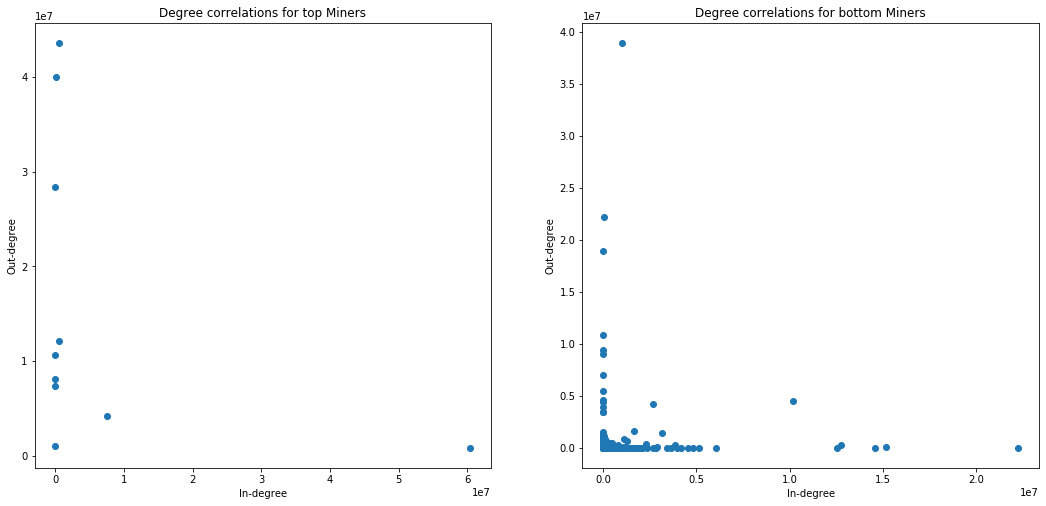

In [186]:
indegree_bottomw=np.array([d for n,d in G_final.in_degree(bottom_miners,weight='value')])*(eth_to_usd/wei_to_eth)
outdegree_bottomw=np.array([d for n,d in G_final.out_degree(bottom_miners,weight='value')])*(eth_to_usd/wei_to_eth)

indegree_top10w=np.array([d for n,d in G_final.in_degree(top_10_miners,weight='value')])*(eth_to_usd/wei_to_eth)
outdegree_top10w=np.array([d for n,d in G_final.out_degree(top_10_miners,weight='value')])*(eth_to_usd/wei_to_eth)



fig=plt.figure(figsize=(18,18))


# Plot in-degree weighted distribution for top nodes
ax=fig.add_subplot(221)
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.yscale('log')
ax.title.set_text('Degree correlations for top Miners')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.scatter(indegree_top10w,outdegree_top10w)

# Plot in-degree weighted distribution for bottom nodes
ax=fig.add_subplot(222)
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.yscale('log')
ax.title.set_text('Degree correlations for bottom Miners')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.scatter(indegree_bottomw,outdegree_bottomw)

In [187]:

# TODO:(How many times their rewards have they sent or received) and see what role do they play in components and control

# TODO: Get value in dollars per transaction at exchange rate at the time to get true measure of econ relationship

**Density**

In [27]:
# Calculate density by components
density_G_final=nx.density(G_final)


G_bottom_miners=G_final.subgraph(bottom_miners)
density_bottom_miners=nx.density(G_bottom_miners)
edges_bottom_miners=[(n1,n2,a['value']) for n1,n2,a in G_bottom_miners.edges(data=True)]
value_bottom_miners=(np.array([e[2] for e in edges_bottom_miners]).sum())*(eth_to_usd/wei_to_eth)

G_top10_miners=G_final.subgraph(top_10_miners)
density_top10_miners=nx.density(G_top10_miners)
edges_top10_miners=[(n1,n2,a['value']) for n1,n2,a in G_top10_miners.edges(data=True)]
value_top10_miners=(np.array([e[2] for e in edges_top10_miners]).sum())*(eth_to_usd/wei_to_eth)

edges_connect=list((set(G_final_edges).difference(set(edges_top10_miners))).difference(set(edges_bottom_miners)))
#edges_connect=list(edges_connect_s10.difference(set(edges_bottom_miners)))
edges_top10_bottom=[e for e in edges_connect if e[0] in list(top_10_miners)]
value_top10_bottom=(np.array([e[2] for e in edges_top10_bottom]).sum())*(eth_to_usd/wei_to_eth)

edges_bottom_top10=[e for e in edges_connect if e[0] in list(bottom_miners)]
value_bottom_top10=(np.array([e[2] for e in edges_bottom_top10]).sum())*(eth_to_usd/wei_to_eth)

print('Density for top 10 miners sub graph: {:.2f}'.format(density_top10_miners))
print('Value transacted between top 10 miners: ${:,.0f}'.format(value_top10_miners))
print('--------')
print('Density for bottom miners sub graph: {:.5f}'.format(density_bottom_miners))
print('Value transacted between bottom miners: ${:,.0f}'.format(value_bottom_miners))
print('--------')
print('Value from top 10 miners to bottom miners: ${:,.0f}'.format(value_top10_bottom))
print('Value from bottom miners to top miners: ${:,.0f}'.format(value_bottom_top10))

print('--------')
print('Checksum: ${:,.0f}'.format(value_bottom_miners+value_top10_miners+value_top10_bottom+value_bottom_top10))
print('Total value: ${:,.0f}'.format(value_trans_final))



Density for top 10 miners sub graph: 0.19
Value transacted between top 10 miners: $8,070,557
--------
Density for bottom miners sub graph: 0.00014
Value transacted between bottom miners: $127,957,543
--------
Value from top 10 miners to bottom miners: $148,310,369
Value from bottom miners to top miners: $60,975,268
--------
Checksum: $345,313,737
Total value: $345,313,737


### Network analysis: Understanding components

**Components - Direct**

<BarContainer object of 2244 artists>

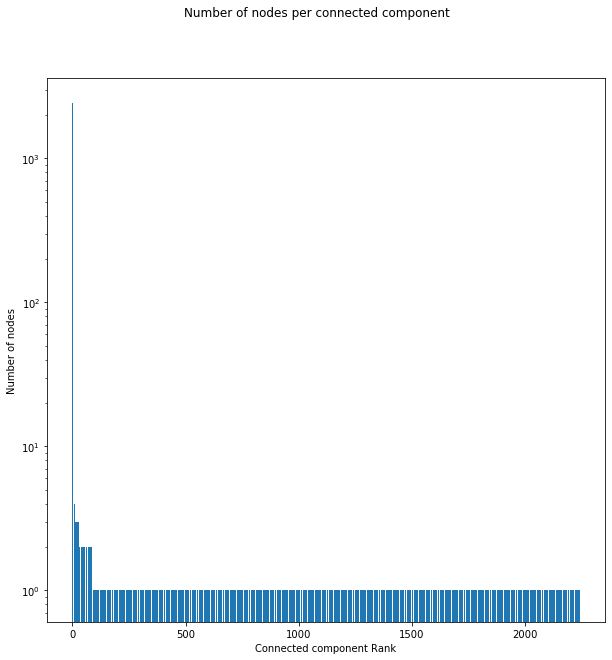

In [29]:
# Define undirected version of Graph
un_G_final=G_final.to_undirected()
un_G_f_comp=[list(c) for c in nx.connected_components(un_G_final)]
un_G_f_comp.sort(key=len,reverse=True)
un_G_f_comp_len=[len(l) for l in un_G_f_comp]


# Plot sizes of strongly connected components
y_pos = np.arange(len(un_G_f_comp_len))
fig,ax=plt.subplots(figsize=(10,10))
plt.yscale('log')
fig.suptitle('Number of nodes per connected component')
plt.xlabel('Connected component Rank')
plt.ylabel('Number of nodes')
plt.bar(y_pos,un_G_f_comp_len)

In [206]:
# Calculate size of GWCC (Giant Weakly Connected Component)
print('Number of weakly connected components: {:,.0f}'.format(len(un_G_f_comp)))



Number of weakly connected components: 2,244


In [135]:
# Analize Giant weakly connected component (GWCC)

G_gwcc_final=G_final.subgraph(un_G_f_comp[0]) #Giant weakly connected component
gwcc_final_nodes=[(n,d['blocks']) for n,d in G_gwcc_final.nodes(data=True)]
gwcc_final_blocks=np.array([a for n,a in gwcc_final_nodes]).sum()
gwcc_final_edges=[(n1,n2,a['value']) for n1,n2,a in G_gwcc_final.edges(data=True)]
gwcc_final_value=np.array([e[2] for e in gwcc_final_edges]).sum()*(eth_to_usd/wei_to_eth)



print('Nodes in GWCC:{:.0f}'.format(len(gwcc_final_nodes)))
print('Hash power in GWCC:{:.0f}%'.format((gwcc_final_blocks/total_blocks)*100))
print('Value transacted in GWCC: ${:,.0f} ({:.0f}% of all value)'.
      format(gwcc_final_value,(gwcc_final_value/value_trans_final)*100))



Nodes in GWCC:2422
Hash power in GWCC:91%
Value transacted in GWCC: $336,196,576 (97% of all value)


**Component Analysis**

In [136]:
# Analize Bowtie structure 

# General sections

# ---Nodes
G_gwcc_out_nodes=[n for n in gwcc_final_nodes if G_gwcc_final.in_degree(n[0])==0]
G_gwcc_in_nodes=[n for n in gwcc_final_nodes if G_gwcc_final.out_degree(n[0])==0]
G_gwcc_mid_nodes=list((set(gwcc_final_nodes).difference(set(G_gwcc_out_nodes))).difference(set(G_gwcc_in_nodes)))

# ---Blocks
out_nodes_blocks=np.array([a for n,a in G_gwcc_out_nodes]).sum()
in_nodes_blocks=np.array([a for n,a in G_gwcc_in_nodes]).sum()
mid_nodes_blocks=np.array([a for n,a in G_gwcc_mid_nodes]).sum()

# ---Edges
G_gwcc_out_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*G_gwcc_out_nodes))[0]]
G_gwcc_in_edges=[e for e in gwcc_final_edges if e[1] in list(zip(*G_gwcc_in_nodes))[0]]
G_gwcc_mid_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*G_gwcc_mid_nodes))[0] and (e[1] in list(zip(*G_gwcc_mid_nodes))[0])]
G_gwcc_outin_edges=[e for e in G_gwcc_in_edges if e[0] in list(zip(*G_gwcc_out_nodes))[0]]
G_gwcc_outmid_edges=list(set(G_gwcc_out_edges).difference(G_gwcc_outin_edges))
G_gwcc_midin_edges=list(set(G_gwcc_in_edges).difference(G_gwcc_outin_edges))

# ---Value
outin_edges_value=np.array([e[2] for e in G_gwcc_outin_edges]).sum()*(eth_to_usd/wei_to_eth)
outmid_edges_value=np.array([e[2] for e in G_gwcc_outmid_edges]).sum()*(eth_to_usd/wei_to_eth)
midin_edges_value=np.array([e[2] for e in G_gwcc_midin_edges]).sum()*(eth_to_usd/wei_to_eth)
mid_edges_value=np.array([e[2] for e in G_gwcc_mid_edges]).sum()*(eth_to_usd/wei_to_eth)

# Detailed sections
# ---Nodes
#-------out nodes
nodes_outin=[e[0] for e in G_gwcc_outin_edges]
nodes_outmid=[e[0] for e in G_gwcc_outmid_edges]
nodes_outmix=list(set(nodes_outin).intersection(set(nodes_outmid)))
nodes_outin_only=list(set(nodes_outin).difference(set(nodes_outmix)))
nodes_outmid_only=list(set(nodes_outmid).difference(set(nodes_outmix)))

#-------mid nodes
nodes_midin=np.unique(np.array([e[0] for e in G_gwcc_midin_edges]))
nodes_in_temp=[n for n,w in G_gwcc_in_nodes]
nodes_out_temp=[n for n,w in G_gwcc_out_nodes]
nodes_midin_only=[n for n in nodes_midin if 
                  all(elem in nodes_in_temp for elem in list(G_gwcc_final.neighbors(n)))
                  and all(elem in nodes_out_temp for elem in list(G_gwcc_final.predecessors(n)))]
nodes_midin_mixed=list(set(list(zip(*G_gwcc_mid_nodes))[0]).difference(set(nodes_midin_only)))

# ----Generate lists including blocks
nodes_outin_only=[n for n in G_gwcc_out_nodes if n[0] in nodes_outin_only]
nodes_outmid_only=[n for n in G_gwcc_out_nodes if n[0] in nodes_outmid_only]
nodes_outmix=[n for n in G_gwcc_out_nodes if n[0] in nodes_outmix]
nodes_midin_only=[n for n in G_gwcc_mid_nodes if n[0] in nodes_midin_only]
nodes_midin_mixed=[n for n in G_gwcc_mid_nodes if n[0] in nodes_midin_mixed]

#---Blocks
outin_only_blocks=np.array([a for n,a in nodes_outin_only]).sum()
outmid_only_blocks=np.array([a for n,a in nodes_outmid_only]).sum()
outmix_blocks=np.array([a for n,a in nodes_outmix]).sum()
midin_only_blocks=np.array([a for n,a in nodes_midin_only]).sum()
midin_mixed_blocks=np.array([a for n,a in nodes_midin_mixed]).sum()


#---Edges
outin_only_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*nodes_outin_only))[0] and 
                  (e[1] in list(zip(*G_gwcc_in_nodes))[0])]
outmid_only_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*nodes_outmid_only))[0] and 
                  (e[1] in list(zip(*G_gwcc_mid_nodes))[0])]
outmix_mid_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*nodes_outmix))[0] and 
                  (e[1] in list(zip(*G_gwcc_mid_nodes))[0])]
outmix_in_edges=[e for e in gwcc_final_edges if e[0] in list(zip(*nodes_outmix))[0] and 
                  (e[1] in list(zip(*G_gwcc_in_nodes))[0])]

#---Value
outin_only_value=np.array([e[2] for e in outin_only_edges]).sum()*(eth_to_usd/wei_to_eth)
outmid_only_value=np.array([e[2] for e in outmid_only_edges]).sum()*(eth_to_usd/wei_to_eth)
outmix_mid_value=np.array([e[2] for e in outmix_mid_edges]).sum()*(eth_to_usd/wei_to_eth)
outmix_in_value=np.array([e[2] for e in outmix_in_edges]).sum()*(eth_to_usd/wei_to_eth)




# Print Values

print('-----G_out')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_out_nodes),(len(G_gwcc_out_nodes)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((out_nodes_blocks/gwcc_final_blocks)*100))
print('Edges to mid: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_outmid_edges),(len(G_gwcc_outmid_edges)/len(gwcc_final_edges))*100))
print('Value transacted to mid: ${:,.0f} ({:.0f}% of all value)'.
      format(outmid_edges_value,(outmid_edges_value/value_trans_final)*100))
print('Edges to in: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_outin_edges),(len(G_gwcc_outin_edges)/len(gwcc_final_edges))*100))
print('Value transacted to in: ${:,.0f} ({:.0f}% of all value)'.
      format(outin_edges_value,(outin_edges_value/value_trans_final)*100))

print('----------G_out mid only')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(nodes_outin_only),(len(nodes_outin_only)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((outmid_only_blocks/gwcc_final_blocks)*100))
print('Edges to mid: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(outmid_only_edges),(len(outmid_only_edges)/len(gwcc_final_edges))*100))
print('Value transacted to mid: ${:,.0f} ({:.0f}% of all value)'.
      format(outmid_only_value,(outmid_only_value/value_trans_final)*100))

print('----------G_out in only')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(nodes_outmid_only),(len(nodes_outmid_only)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((outin_only_blocks/gwcc_final_blocks)*100))
print('Edges to in: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(outin_only_edges),(len(outin_only_edges)/len(gwcc_final_edges))*100))
print('Value transacted to in: ${:,.0f} ({:.0f}% of all value)'.
      format(outin_only_value,(outin_only_value/value_trans_final)*100))

print('----------G_out mixed')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(nodes_outmix),(len(nodes_outmix)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((outmix_blocks/gwcc_final_blocks)*100))
print('Edges to mid: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(outmix_mid_edges),(len(outmix_mid_edges)/len(gwcc_final_edges))*100))
print('Value transacted to mid: ${:,.0f} ({:.0f}% of all value)'.
      format(outmix_mid_value,(outmix_mid_value/value_trans_final)*100))
print('Edges to in: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(outmix_in_edges),(len(outmix_in_edges)/len(gwcc_final_edges))*100))
print('Value transacted to in: ${:,.0f} ({:.0f}% of all value)'.
      format(outmix_in_value,(outmix_in_value/value_trans_final)*100))

print('-----G_mid')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_mid_nodes),(len(G_gwcc_mid_nodes)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((mid_nodes_blocks/gwcc_final_blocks)*100))
print('Edges inside mid: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_mid_edges),(len(G_gwcc_mid_edges)/len(gwcc_final_edges))*100))
print('Value transacted inside mid: ${:,.0f} ({:.0f}% of all value)'.
      format(mid_edges_value,(mid_edges_value/value_trans_final)*100))
print('Edges to in: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_midin_edges),(len(G_gwcc_midin_edges)/len(gwcc_final_edges))*100))
print('Value transacted to in: ${:,.0f} ({:.0f}% of all value)'.
      format(midin_edges_value,(midin_edges_value/value_trans_final)*100))


print('-----G_in')

print('Nodes: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(G_gwcc_in_nodes),(len(G_gwcc_in_nodes)/len(gwcc_final_nodes))*100))
print('Hashing power: {:.2f}% '
      .format((in_nodes_blocks/gwcc_final_blocks)*100))

print('-----Sumchecks')

print('Checksum total nodes: {:.3f}'
      .format((len(G_gwcc_out_nodes)+len(G_gwcc_in_nodes)+len(G_gwcc_mid_nodes))/len(gwcc_final_nodes)))
print('Checksum out nodes: {:.3f}'
      .format((len(nodes_outin_only)+len(nodes_outmid_only)+len(nodes_outmix))/len(G_gwcc_out_nodes)))
print('Checksum mid nodes: {:.3f}'
      .format((len(nodes_midin_only)+len(nodes_midin_mixed))/len(G_gwcc_mid_nodes)))





-----G_out
Nodes: 876 (36% of all in gwcc )
Hashing power: 4.05% 
Edges to mid: 895 (18% of all in gwcc )
Value transacted to mid: $45,553,968 (13% of all value)
Edges to in: 679 (14% of all in gwcc )
Value transacted to in: $14,927,070 (4% of all value)
----------G_out mid only
Nodes: 123 (5% of all in gwcc )
Hashing power: 0.64% 
Edges to mid: 740 (15% of all in gwcc )
Value transacted to mid: $40,348,021 (12% of all value)
----------G_out in only
Nodes: 727 (30% of all in gwcc )
Hashing power: 0.32% 
Edges to in: 136 (3% of all in gwcc )
Value transacted to in: $1,692,566 (0% of all value)
----------G_out mixed
Nodes: 26 (1% of all in gwcc )
Hashing power: 3.10% 
Edges to mid: 155 (3% of all in gwcc )
Value transacted to mid: $5,205,947 (2% of all value)
Edges to in: 543 (11% of all in gwcc )
Value transacted to in: $13,234,504 (4% of all value)
-----G_mid
Nodes: 410 (17% of all in gwcc )
Hashing power: 91.46% 
Edges inside mid: 1000 (21% of all in gwcc )
Value transacted inside mid

/Users/dsrincon/anaconda/envs/graphanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


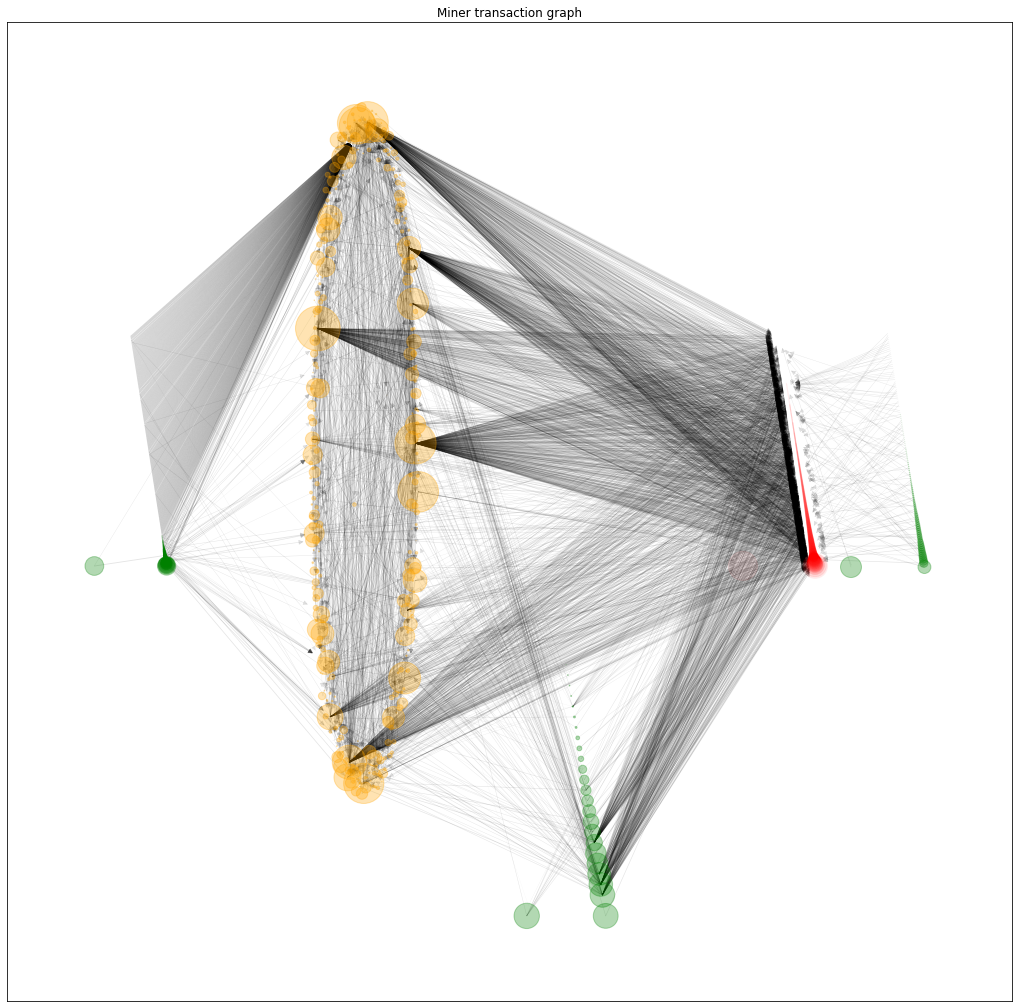

In [412]:
# Draw Transaction Graph for components

nodes_lists=[nodes_outin_only,nodes_outmid_only,nodes_outmix,G_gwcc_mid_nodes,G_gwcc_in_nodes]


fig=plt.figure(figsize=(18,18))
draw_bowtie_graph(fig,G_gwcc_final,nodes_lists,'blocks',
                      G_gwcc_final.edges(data=True),'value',111,edge_type='')

**Strongly connected components (Collusion?)**

In [148]:

# Define subgraph of mid (in-out) nodes
G_mid=G_gwcc_final.subgraph(list(zip(*G_gwcc_mid_nodes))[0])

#Calculate density and diameter measures
density_mid=nx.classes.function.density(G_mid)*100

print('Density for Mid graph: %{:,.3f} ({:,.0f} times more dense than the overall graph)'.format(density_mid,density_mid/(density_final*100)))



Density for Mid graph: %0.596 (28 times more dense than the overall graph)


<BarContainer object of 73 artists>

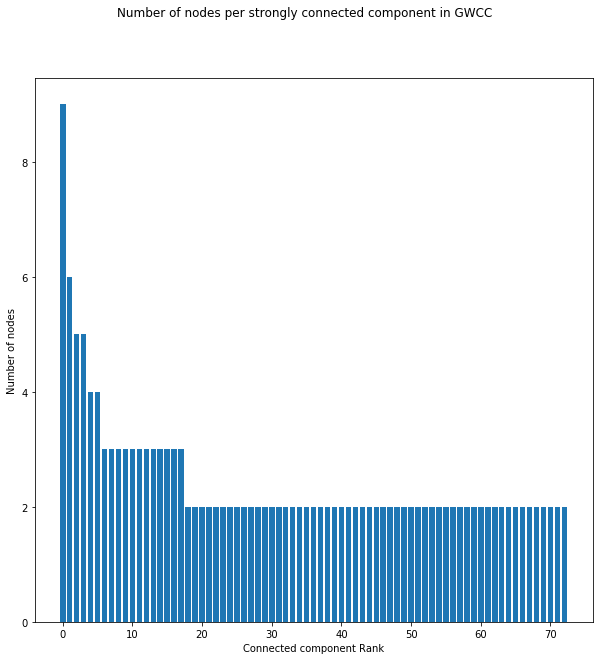

In [137]:
# Analize Strongly Connected Components (SCC) in GWCC

scc_gen=nx.strongly_connected_components(G_gwcc_final) 
scc_lists=[tuple(s) for s in scc_gen if len(tuple(s))>1] # List of strongly connected components in the gwcc
scc_list_len=[len(l) for l in scc_lists]
scc_lists.sort(key=len,reverse=True)
scc_list_len.sort(reverse=True)

# Graph distribution of sizes of strongly connected components in GWCC
#print(scc_lists)
y_pos = np.arange(len(scc_list_len))
fig,ax=plt.subplots(figsize=(10,10))
#plt.yscale('log')
fig.suptitle('Number of nodes per strongly connected component in GWCC')
plt.xlabel('Connected component Rank')
plt.ylabel('Number of nodes')
plt.bar(y_pos,scc_list_len)

Total nodes in SCCs:179
Total hashing power in SCCs:44%
Total hashing power of largest SCCs:16%
Total value in SCCs:$62,741,700
SCCs with top 10 miners [(1, 961, 356, 7, 720, 309, 341, 2649, 25), (4, 5), (21, 6), (8, 64)]


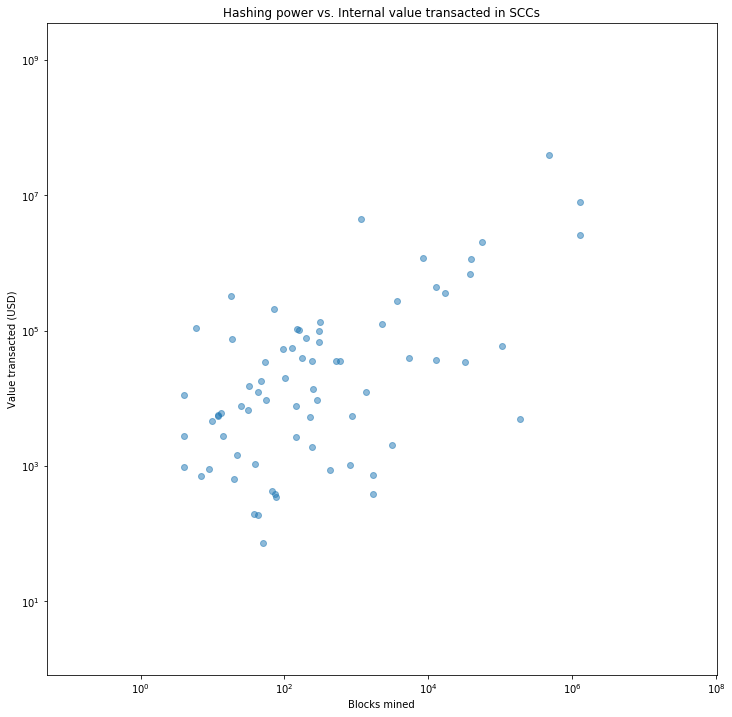

In [185]:

# Nodes in SCCs
nodes_sccs=[len(l) for l in scc_lists]
nodes_sccs.sort(reverse=True)
total_nodes_scc=np.array(nodes_sccs).sum()

# SCCs with top 10 nodes

sccs_top10=[l for l in scc_lists if any(elem in top_10_miners for elem in l)]

# Hashing power in SCCs
blocks_sccs=[[G_mid.nodes(data=True)[n]['blocks'] for n in l] for l in scc_lists]
block_sum_sccs=[np.array(l).sum() for l in blocks_sccs]
total_blocks_sccs=np.array(block_sum_sccs).sum()


# Edges in SCCs
edges_sccs=[list(G_mid.subgraph(l).edges(data=True)) for l in scc_lists]

# Value in SCCs
values_sccs=[[e[2]['value'] for e in edges] for edges in edges_sccs]
value_sum_sccs=[np.array(l).sum()*(eth_to_usd/wei_to_eth) for l in values_sccs]
total_value_sccs=np.array(value_sum_sccs).sum()



print('Total nodes in SCCs:{:,.0f}'.format(total_nodes_scc))
print('Total hashing power in SCCs:{:,.0f}%'.format((total_blocks_sccs/gwcc_final_blocks)*100))
print('Total hashing power of largest SCCs:{:,.0f}%'.format((block_sum_sccs[0]/gwcc_final_blocks)*100))
print('Total value in SCCs:${:,.0f}'.format(total_value_sccs))
print('SCCs with top 10 miners {}'.format(sccs_top10))


# Graph Value transacted vs. hash power per SCC
fig=plt.figure(figsize=(12,12))


# Plot in-degree weighted distribution for top nodes
ax=fig.add_subplot(111)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.yscale('log')
plt.xscale('log')
ax.title.set_text('Hashing power vs. Internal value transacted in SCCs')
plt.xlabel('Blocks mined')
plt.ylabel('Value transacted (USD)')
plt.scatter(block_sum_sccs,value_sum_sccs,alpha=0.5)


In [91]:
#Strongly connected components in condensation
condensation_scc_gen=nx.strongly_connected_components(condensation)
condensation_scc_nodes=[list(s) for s in condensation_scc_gen]
print(len(condensation.nodes()))
print(condensation_scc_nodes[:10])

print('---Distance metrics--')
#print('Average distance (shortest path) in GWCC: {:,.3f}'.format(gwcc_av_distance))
#print('Diameter of GWCC: {:,.3f}'.format(gwcc_diameter))
#print('Reciprocity of GWCC: {:,.3f}'.format(gwcc_reciprocity))
print(gwcc_distances[:2400])

2316
[[73], [74], [188], [189], [80], [190], [191], [192], [83], [193]]


In [ ]:
#TODO: # Analize Distance measures for GWCC Seems that every node has 

gwcc_distances=[nx.algorithms.shortest_paths.unweighted.single_source_shortest_path(G_gwcc_final,n)
               for n in list(zip(*G_gwcc_in_nodes))[0]]

#gwcc_av_distance=nx.algorithms.shortest_paths.generic.average_shortest_path_length(G_gwcc_final)
#gwcc_diameter=nx.algorithms.distance_measures.diameter(G_gwcc_final)
#gwcc_reciprocity=nx.algorithms.reciprocity.reciprocity(G_gwcc_final)


In [92]:
cond_out_degrees=condensation.out_degree()
cond_in_degrees=condensation.in_degree()


In [102]:

cond_out=[t[0] for t in cond_out_degrees if t[1]>0]
cond_in=[t[0] for t in cond_in_degrees if t[1]>0]
cond_in_out=list(set(cond_out).intersection(set(cond_in)))
print('Input component size={}'.format(len(cond_out)-len(cond_in_out)))
print('Output component size={}'.format(len(cond_in)-len(cond_in_out)))
print('In and out component size={}'.format(len(cond_in_out)))

Input component size=906
Output component size=1219
In and out component size=191


**Gradient**

In [417]:
# Quantify Transactions against gradient gwcc
gwcc_final_edges
edges_against=[e for e in gwcc_final_edges if e[1]<e[0]]
percent_against=[1-e[1]/e[0] for e in edges_against] #Percentage of the total possible distance against the gradient covered
mean_percent_against=np.array(percent_against).mean()
value_against=np.array([e[2] for e in edges_against]).sum()*(eth_to_usd/wei_to_eth)

print('Edges transacted against the gradient: {:.0f} ({:.0f}% of all in gwcc )'
      .format(len(edges_against),(len(edges_against)/len(gwcc_final_edges))*100))
print('Value transacted against the gradient: ${:,.0f} ({:.0f}% of all value)'.
      format(value_against,(value_against/value_trans_final)*100))
print('Average % of total negative gradient: {:,.2f}%'.
      format(mean_percent_against*100))



Edges transacted against the gradient: 1088 (22% of all in gwcc )
Value transacted against the gradient: $104,730,651 (30% of all value)
Average % of negative gradient coverd by transaction: 77.73%


**Control**

In [189]:
# Control from cononical time invariant dyanamics

driver_nodes=nxc.algorithms.maximum_matching_driver_nodes(G_gwcc_final)
driver_nodes=[n for n in gwcc_final_nodes if n[0] in driver_nodes]
driver_nodes_blocks=np.array([b for n,b in driver_nodes]).sum()
print('Number of driver nodes: {:.0f}'.format(len(driver_nodes)))
print('Hash power of driver nodes: {:.3f}'.format((driver_nodes_blocks/total_blocks)*100))

# TODO: Find control set with minimum hash power
'''


Number of driver nodes: 1945
Hash power of driver nodes: 46.974


In [190]:
# Minimum Dominating set
sorted_dom_sets=[(y,x) for y,x in sorted(zip(dom_set_block_h,dom_set_l))]
min_dom_set=sorted_dom_sets[0][1]
min_dom_set_h=sorted_dom_sets[0][0]
min_dom_set.sort()

print(min_dom_set[:5])

min_dom_set_out=[n for n in min_dom_set if n in G_gwcc_out_nodes]
min_dom_set_in=[n for n in min_dom_set if n in G_gwcc_in_nodes]
min_dom_set_mid=[n for n in min_dom_set if n in G_gwcc_mid_nodes]

print('Size of minimum dominating set: {:.0f}'.format(len(min_dom_set)))
print('Hash power of minimum dominating set: %{:.2f}'.format((min_dom_set_h/total_blocks)*100))

print('Number of miners in dominating set from out: {:.0f}'.format(len(min_dom_set_out)))
print('Number of miners in dominating set from in: {:.0f}'.format(len(min_dom_set_in)))
print('Number of miners in dominating set from mid: {:.0f}'.format(len(min_dom_set_mid)))

[(1, 961958.0), (6, 443067.0), (9, 162265.0), (14, 55651.0), (15, 48848.0)]
Size of minimum dominating set: 1398
Hash power of minimum dominating set: %25.25
Number of miners in dominating set from out: 826
Number of miners in dominating set from in: 420
Number of miners in dominating set from mid: 152


In [80]:
# Predecesors top 10
blocks=nx.get_node_attributes(G_gwcc_final,'blocks')
drivers_top=[]
drivers_top_hash=[]
for i in range (10):
    predecessors_i=list(G_gwcc_final.predecessors(i))
    predecessors_i.sort(reverse=True)
    driver_i=predecessors_i[0]
    driver_i_hash=blocks[driver_i]
    if (not driver_i in drivers_top):
        drivers_top.append(driver_i)
        drivers_top_hash.append(driver_i_hash)

  
top_dom_set_out=[n for n in drivers_top if n in list(zip(*G_gwcc_out_nodes))[0]]
top_dom_set_in=[n for n in drivers_top if n in list(zip(*G_gwcc_in_nodes))[0]]
top_dom_set_mid=[n for n in drivers_top if n in list(zip(*G_gwcc_mid_nodes))[0]]

drivers_top_blocks=np.array(drivers_top_hash).sum()    
print('Top 10 miners in dominating set:{}'.format(drivers_top))   
print('Top 10 miners in dominating set hashing power:{:.2f}%'.format((drivers_top_blocks/total_blocks)*100))   

print('Number of miners in dominating set from out: {:.0f}'.format(len(top_dom_set_out)))
print('Number of miners in dominating set from in: {:.0f}'.format(len(top_dom_set_in)))
print('Number of miners in dominating set from mid: {:.0f}'.format(len(top_dom_set_mid)))
 

Top 10 miners in dominating set:[155, 309, 23, 3, 5, 156, 64, 3123]
Top 10 miners in dominating set hashing power:15.66%
Number of miners in dominating set from out: 3
Number of miners in dominating set from in: 0
Number of miners in dominating set from mid: 5


In [55]:
gwcc_final_nodes_s=[n[0] for n in gwcc_final_nodes]
gwcc_final_nodes_s.sort(reverse=True)

print(gwcc_final_nodes_s[:100])

[4982, 4980, 4979, 4978, 4977, 4976, 4973, 4970, 4969, 4966, 4965, 4959, 4958, 4957, 4955, 4954, 4952, 4949, 4948, 4947, 4946, 4945, 4943, 4939, 4938, 4937, 4936, 4935, 4933, 4932, 4931, 4930, 4929, 4928, 4926, 4925, 4923, 4919, 4917, 4916, 4914, 4912, 4910, 4909, 4906, 4904, 4901, 4900, 4899, 4898, 4897, 4894, 4893, 4892, 4890, 4888, 4883, 4880, 4879, 4878, 4877, 4875, 4874, 4873, 4872, 4871, 4870, 4868, 4867, 4865, 4864, 4863, 4862, 4860, 4859, 4857, 4856, 4853, 4852, 4847, 4846, 4845, 4844, 4843, 4841, 4840, 4837, 4834, 4833, 4830, 4829, 4828, 4820, 4819, 4818, 4815, 4813, 4812, 4811, 4809]


**What explains links and values**

**Communities** (Not useful)

In [238]:
communities_G_final=nx.algorithms.community.label_propagation.asyn_lpa_communities(G_final, weight='value')

In [239]:
communities_G_final=[c for c in communities_G_final]
print('Size of communities: {}'.format(len(communities_G_final)))

Size of communities: 3502


## Appendix Functions

In [15]:
#Function that plots bowtie graph with out, in and mid nodes as input

def draw_bowtie_graph(fig,G,nodes_lists,nodes_weight_v,
                      edges,edge_width_v,subplot_q,edge_type=''):

    nodes_outin_only=nodes_lists[0]
    nodes_outmid_only=nodes_lists[1]
    nodes_outmix=nodes_lists[2]
    nodes_mid=nodes_lists[3]
    nodes_in=nodes_lists[4]
    '''
    edges=[(e[0],e[1]) for e in edges]
    print(edges[:5])
    
    return
    '''
    # Create percentile rank per node based on weights
    # -----get node weights
    outin_only_weights=[w for n,w in nodes_outin_only]
    outmid_only_weights=[w for n,w in nodes_outmid_only]
    outmix_weights=[w for n,w in nodes_outmix]
    nodes_mid_weights=[w for n,w in nodes_mid]
    nodes_in_weights=[w for n,w in nodes_in]

    
    #------get max weight and calculate percentile array for all nodes
  
    all_weights=np.array(outin_only_weights+outmid_only_weights+outmix_weights+nodes_mid_weights
                         +nodes_in_weights)
    max_weight=np.max(all_weights)
    all_weights=((np.power(np.log(all_weights),4))/(np.power(np.log(max_weight),4)))*2000
    all_weights_per=all_weights
    #all_weights_per=np.array([percentileofscore(all_weights,w,'rank') for w in all_weights])/5
    
    #------Define simple node lists
    
    
    nodes_outin_only=[n for n,w in nodes_outin_only]
    nodes_outmid_only=[n for n,w in nodes_outmid_only]
    nodes_outmix=[n for n,w in nodes_outmix]
    nodes_mid=[n for n,w in nodes_mid]
    nodes_in=[n for n,w in nodes_in]
    
    n_lists=[nodes_outin_only,nodes_outmid_only,nodes_outmix,nodes_mid,nodes_in]
    
     
        
    #------Split node percentile array into arrays for out, min, in
    outin_only_weights_per=all_weights_per[0:len(nodes_outin_only)]
    outmid_only_weights_per=all_weights_per[len(nodes_outin_only):len(nodes_outin_only)+len(nodes_outmid_only)]
    outmix_weights_per=all_weights_per[len(nodes_outin_only)+len(nodes_outmid_only)
                                       :len(nodes_outin_only)+len(nodes_outmid_only)+len(nodes_outmix)]
    mid_weights_per=all_weights_per[len(nodes_outin_only)+len(nodes_outmid_only)+len(nodes_outmix)
                                       :len(nodes_outin_only)+len(nodes_outmid_only)+len(nodes_outmix)+len(nodes_mid)]
    in_weights_per=all_weights_per[len(nodes_outin_only)+len(nodes_outmid_only)+len(nodes_outmix)+len(nodes_mid):]
   
    w_lists=[outin_only_weights_per,outmid_only_weights_per,outmix_weights_per,mid_weights_per,in_weights_per]
    
    
    # Define circular layout and list of node sizes
    pos_outin_only=nx.planar_layout(nodes_outin_only,center=(6,0))
    pos_outmid_only=nx.planar_layout(nodes_outmid_only,center=(-8,0))
    pos_outmix=nx.planar_layout(nodes_outmix,center=(0,-1))
    pos_mid=nx.spring_layout(nodes_mid,center=(-4,0))
    pos_in=nx.planar_layout(nodes_in,center=(4,0))
    
    
    total_pos=pos_outin_only
    total_pos.update(pos_outmid_only)
    total_pos.update(pos_outmix)
    total_pos.update(pos_mid)
    total_pos.update(pos_in)
    
    

    
    # Create percentile rank per edge based on weights

    values=np.array([d[edge_width_v] for _,_,d in edges])
    max_value=np.max(values)
    #values=values/max_value
    values_per=((np.power(np.log(values),6))/(np.power(np.log(max_value),4)))
    #values_per=np.array([percentileofscore(values,v,'rank') for v in values])/100

    # Create label dictionary
    
    #lab_dic={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'10'}
    
    # Draw nodes and edges
    ax=fig.add_subplot(subplot_q)
    ax.title.set_text('Miner transaction graph')
    node_colors=['green','green','green','orange','red']
    
    for i in range(len(n_lists)):
    
        if(node_colors[i]=='red'):
            nx.draw_networkx_nodes(G, total_pos, nodelist=n_lists[i], 
                           node_size=w_lists[i], node_color=node_colors[i], alpha=0.05)
        else:
            nx.draw_networkx_nodes(G, total_pos, nodelist=n_lists[i], 
                           node_size=w_lists[i], node_color=node_colors[i], alpha=0.3)
   
    
    nx.draw_networkx_edges(G,total_pos,edgelist=edges,alpha=0.1,width=values_per)
    #nx.draw_networkx_labels(G, total_pos, labels=lab_dic, font_size=12, font_color='k', 
                         #font_family='sans-serif', font_weight='normal', alpha=None, bbox=None, ax=None, **kwds)
    
    return

In [14]:
def draw_2node_graph(fig,G,nodes_1,nodes_2,edges,edge_width_v,subplot_q,edge_type=''):

    # Sample a max of 5000 edges to reduce plotting time and increase visibility
    init_edges=len(edges)
    #if init_edges>max_sample:
    #   edges=random.sample(edges, max_sample)
    trimmed_edges=len(edges)

    
    
    
    
    # Define circular layout 
    pos_o=nx.spring_layout(nodes_1, scale=1)
    pos_n=nx.spring_layout(nodes_2, scale=0.9)
    total_pos=pos_o
    total_pos.update(pos_n)


    # Define transactions to show (incoming edges)

    values=np.array([d[edge_width_v] for _,_,d in edges])
    max_value=np.max(values)
    values=values/max_value
    values_per=np.array([percentileofscore(values,v,'rank') for v in values])/100

    
    # Draw nodes and edges
    ax=fig.add_subplot(subplot_q)
    ax.title.set_text('Transaction Graph for Block {} - {} \n ({} Old Nodes / {} New Nodes / {} Edges)'.
                      format(G.graph['graph_id'],edge_type,len(nodes_1),len(nodes_2),init_edges))
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_1, node_size=1, node_color='blue', alpha=0.3)
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_2, node_size=2, node_color='red', alpha=0.5)
    nx.draw_networkx_edges(G,total_pos,edgelist=edges,alpha=0.1,width=values_per)
    
    return

In [13]:
# Function to calculate gini coefficient taken from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python

def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

### Notes

In [ ]:
# Refinements
# TODO: **Network Centrality vs. Hashing importance**
# TODO: # Analize Distance measures for GWCC. (Check self-loops and if they affect results significantly)
# TODO: Improve graphing function
# TODO: Measue hashing power given relative importance and hashing difficulty at the moment of mining. 

